In [1]:
# Imports
import os
import random
from glob import glob
import cv2 
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

import argparse
#import torch
#import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

# Oversampling data

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.uint8)
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Carregar os dados balanceados
data_resampled = np.load('data/train_resampled.npz')
x_train_resampled = data_resampled['images']
y_train_resampled = data_resampled['labels']

# Verificar a distribuição de classes
from collections import Counter
print("Distribuição de classes no conjunto de treino carregado:")
print(Counter(y_train_resampled))

# Load the data(images)
x_npz = np.load("data/x_images_arrays.npz")
X = x_npz["arr_0"]
y_npz = np.load("data/y_labels_arrays.npz")
Y = y_npz["arr_0"]

print(np.array(X).shape)
print(np.array(Y).shape)

# Separete the data into train, val and test sets
# 80% train, 10% val, 10% test
x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2,random_state=1, stratify=Y)

x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

print(np.array(x_train).shape)
print(np.array(x_val).shape)
print(np.array(x_test).shape)
# (3045, 128, 128, 3)
# (381, 128, 128, 3)
# (381, 128, 128, 3)

# Transform the data to tensor
# Define a transform
transform = transforms.Compose([
            #transforms.Resize((28, 28)),
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Apply the transform to the data
dataset_train_resampled = CustomImageDataset(x_train_resampled, y_train_resampled, transform=transform)
dataset_val = CustomImageDataset(x_val, y_val, transform=transform)
dataset_test = CustomImageDataset(x_val, y_val, transform=transform)

img, label = dataset_train_resampled[0]
print(img.shape, label) # [grayscale=1, size=128, size=128] label=0 ('Nothing')
print(dataset_train_resampled.__len__()) # 3045 images
print(dataset_val.__len__()) # 381 images
print(dataset_test.__len__()) # 381 images

# Load into the DataLoader
batch_size = 32

train_loader_over = DataLoader(dataset_train_resampled, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

Distribuição de classes no conjunto de treino carregado:
Counter({np.int64(0): 2435, np.int64(2): 2435, np.int64(1): 2435})
(3807, 128, 128, 3)
(3807,)
(3045, 128, 128, 3)
(381, 128, 128, 3)
(381, 128, 128, 3)
torch.Size([1, 128, 128]) 0
7305
381
381


# Network

### Define

In [ ]:
# Network Architecture
entry_channels = 1
exit_channels = 16
kernel_size = 3
stride = 1
num_inputs = 128*128
num_hidden = 1000
num_outputs = 3 # classes

# Use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(entry_channels, exit_channels, kernel_size, stride, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(exit_channels*num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)  # Ativação após conv1
        #x = F.max_pool2d(x, 2)  # Reduz dimensões (opcional, ajusta tamanho)
        x = torch.flatten(x, 1)  # Achatamento
        x = self.fc1(x)
        x = F.relu(x)  # Ativação após fc1
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)  # Saída com softmax
        return output

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 32 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

### Training loop

In [10]:
num_epochs = 1
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=5e-4)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

for epoch in range(num_epochs):
    train(model, device, train_loader_over, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 0 [0/7305 (0%)]	Loss: 1.099274
Train Epoch: 0 [1024/7305 (14%)]	Loss: 1.095217
Train Epoch: 0 [2048/7305 (28%)]	Loss: 1.093138
Train Epoch: 0 [3072/7305 (42%)]	Loss: 1.092823
Train Epoch: 0 [4096/7305 (56%)]	Loss: 1.064038
Train Epoch: 0 [5120/7305 (70%)]	Loss: 1.045932
Train Epoch: 0 [6144/7305 (84%)]	Loss: 1.058916
Train Epoch: 0 [7168/7305 (98%)]	Loss: 1.061266

Test set: Average loss: 1.0908, Accuracy: 114/381 (30%)



In [ ]:
PATH = './models/cnn2_over.pth'
torch.save(model.state_dict(), PATH)
print(f"Model saved to {PATH}") 

Model saved to ./models/cnn2_over.pth


### Metrics

In [11]:
# Função para calcular métricas
def calculate_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro') # average = 'weighted' | 'micro' | 'macro'
    return precision, recall, f1

# Listas para armazenar previsões e rótulos verdadeiros
all_preds = []
all_targets = []

# Avaliação do modelo
total = 0
correct = 0

with torch.no_grad():
    model.eval()
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        test_data = model(data)

        # Previsões
        _, predicted = test_data.max(1)

        # Acumular acurácia
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        # Armazenar previsões e rótulos para F1 e matriz de confusão
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calcular acurácia
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

# Calcular precisão, recall e F1-score
precision, recall, f1 = calculate_metrics(all_targets, all_preds) 
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

# Calcular e exibir a matriz de confusão
conf_matrix = confusion_matrix(all_targets, all_preds)
print("\nMatriz de Confusão:")
print(conf_matrix)

Total correctly classified test set images: 114/381
Test Set Accuracy: 29.92%
Precision: 0.35
Recall: 0.35
F1-score: 0.23

Matriz de Confusão:
[[ 77  43 184]
 [  3   3  20]
 [ 10   7  34]]


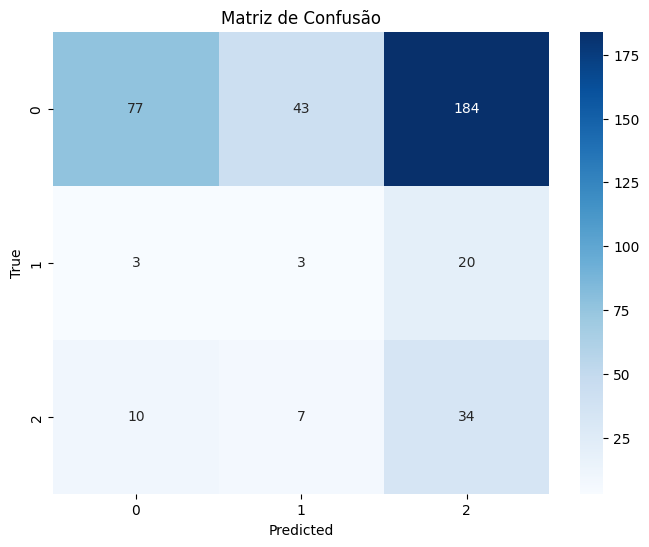

In [12]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()